# **Download libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

# **DATA PREPROCESSING for ResNet50:**
1.   Download CIFAR 10 datasets
2.   Normalization
3.   Data augamntation
4.   Resizing


In [8]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Preprocessing function
def preprocess_images(images, labels):
    images = tf.image.resize(images, (224, 224))
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    images = tf.image.random_flip_left_right(images)
    return images, labels

*   **converts data to TensorFlow dataset for faster loading**
*   **enables mixed-precision training (float16) to improve performance and reduce memory usage.**
*   **Load ResNet50 Model**






In [9]:
# Convert dataset to TensorFlow Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess_images).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess_images).batch(64).prefetch(tf.data.AUTOTUNE)

# Enable mixed precision for performance boost
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load ResNet-50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# **prepare the model for training**

In [10]:
# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax', dtype='float32')(x)  # 10 classes for CIFAR-10
model = Model(inputs=base_model.input, outputs=x)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Model Training**

In [11]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train model
history = model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[early_stopping, reduce_lr])


Epoch 1/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 176ms/step - accuracy: 0.3565 - loss: 1.9733 - val_accuracy: 0.7721 - val_loss: 0.7445 - learning_rate: 1.0000e-05
Epoch 2/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.7976 - loss: 0.6580 - val_accuracy: 0.8315 - val_loss: 0.5164 - learning_rate: 1.0000e-05
Epoch 3/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 122s 157ms/step - accuracy: 0.8442 - loss: 0.4819 - val_accuracy: 0.8521 - val_loss: 0.4398 - learning_rate: 1.0000e-05
Epoch 4/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 158ms/step - accuracy: 0.8635 - loss: 0.4125 - val_accuracy: 0.8663 - val_loss: 0.3985 - learning_rate: 1.0000e-05
Epoch 5/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.8740 - loss: 0.3739 - val_accuracy: 0.8732 - val_loss: 0.3734 - learning_rate: 1.0000e-05
Epoch 6/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.8827 - loss: 0.3458 - val_accuracy: 0.8820 - val_loss: 0.3546 - learning_rate: 1.0000e-05
Epoch 7/200
782/782 ━━━━━━━━━━━━━━

# **Model Evaluation**

*   **Confusion matrix**
*   **plot figure**



In [12]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predict classes
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true_one_hot = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true_one_hot, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=class_names))

157/157 - 20s - 129ms/step - accuracy: 0.9131 - loss: 0.2544
Test Accuracy: 91.31%
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.92      0.93      0.93      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.92      0.88      0.90      1000
         cat       0.83      0.84      0.83      1000
        deer       0.89      0.91      0.90      1000
         dog       0.90      0.87      0.88      1000
        frog       0.92      0.94      0.93      1000
       horse       0.93      0.93      0.93      1000
        ship       0.94      0.95      0.95      1000
       truck       0.94      0.93      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



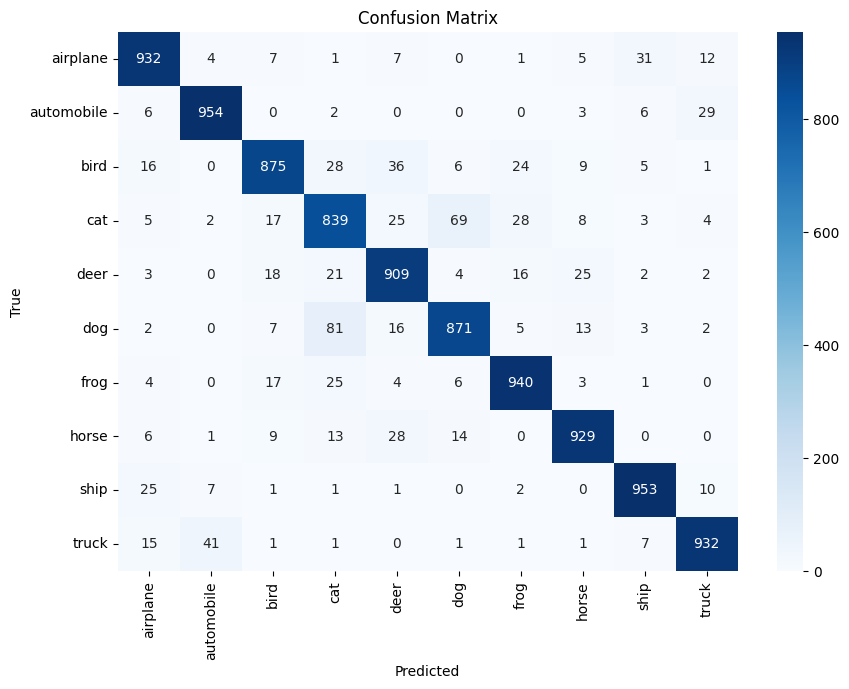

In [13]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

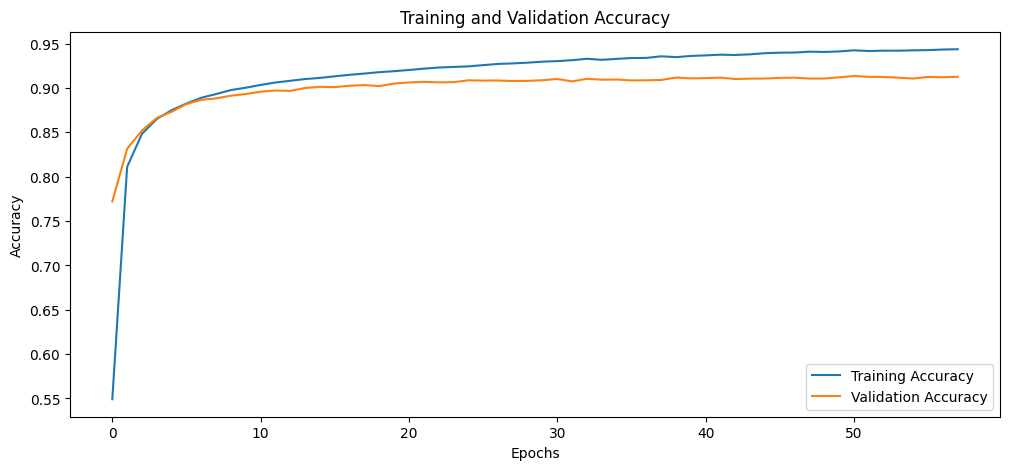

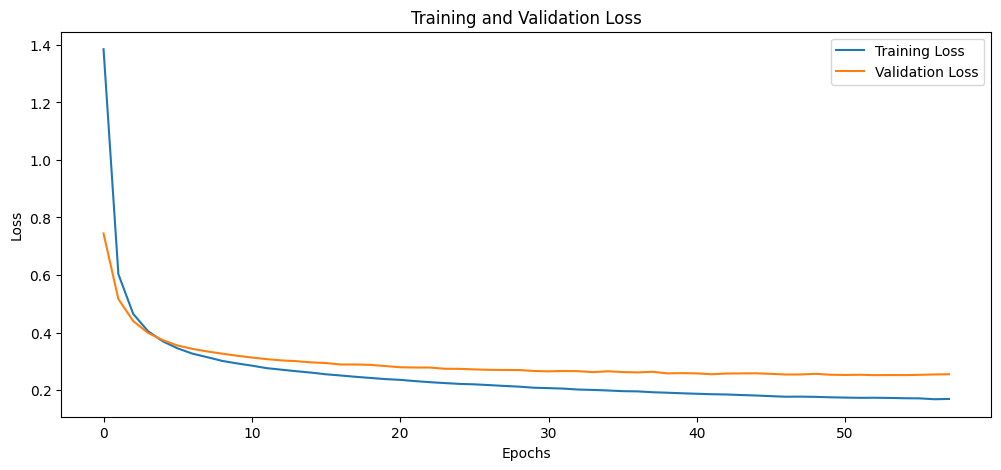

In [14]:
# Training and validation accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and validation loss plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model.save('ResNet_model.h5')

# **DATA PREPROCESSING for VGG16:**
1.   Download CIFAR 10 datasets
2.   Normalization
3.   Data augamntation
4.   Resizing

In [24]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


# Preprocessing function
def preprocess_images(images, labels):
    images = tf.image.resize(images, (224, 224))
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    images = tf.image.random_flip_left_right(images)
    return images, labels

* converts data to TensorFlow dataset for faster loading
* enables mixed-precision training (float16) to improve performance and reduce memory usage.




In [25]:
# Prepare dataset
batch_size = 32
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                 .map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                .map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

**Load VGG16 model & build the model**

In [26]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224, 224, 3))
base_model.trainable = False

# Fine-tune last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax', dtype='float32')(x)
model = Model(inputs=base_model.input, outputs=x)

# **Train the model**

In [27]:
# Clear any previous session
tf.keras.backend.clear_session()

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train model
history = model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 95ms/step - accuracy: 0.4747 - loss: 1.5109 - val_accuracy: 0.8249 - val_loss: 0.5342 - learning_rate: 1.0000e-04
Epoch 2/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.8387 - loss: 0.4882 - val_accuracy: 0.8670 - val_loss: 0.3926 - learning_rate: 1.0000e-04
Epoch 3/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.8899 - loss: 0.3265 - val_accuracy: 0.8967 - val_loss: 0.3133 - learning_rate: 1.0000e-04
Epoch 4/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.9133 - loss: 0.2591 - val_accuracy: 0.8816 - val_loss: 0.3713 - learning_rate: 1.0000e-04
Epoch 5/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 90ms/step - accuracy: 0.9305 - loss: 0.2067 - val_accuracy: 0.8827 - val_loss: 0.3884 - learning_rate: 1.0000e-04
Epoch 6/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 90ms/step - accuracy: 0.9396 - loss: 0.1776 - val_accuracy: 0.8832 - val_loss: 0.4072 - learning_rate: 1.0000e-04
Epoch 7/200
1563/1563 ━━━━━━

# **Evaluate VGG16 model**

In [28]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_one_hot = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true_one_hot, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

313/313 - 7s - 22ms/step - accuracy: 0.9221 - loss: 0.2677
Test Accuracy: 92.21%
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.92      0.95      0.94      1000
  automobile       0.94      0.98      0.96      1000
        bird       0.90      0.91      0.91      1000
         cat       0.89      0.81      0.85      1000
        deer       0.92      0.92      0.92      1000
         dog       0.82      0.92      0.87      1000
        frog       0.96      0.94      0.95      1000
       horse       0.96      0.92      0.94      1000
        ship       0.95      0.96      0.95      1000
       truck       0.98      0.92      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



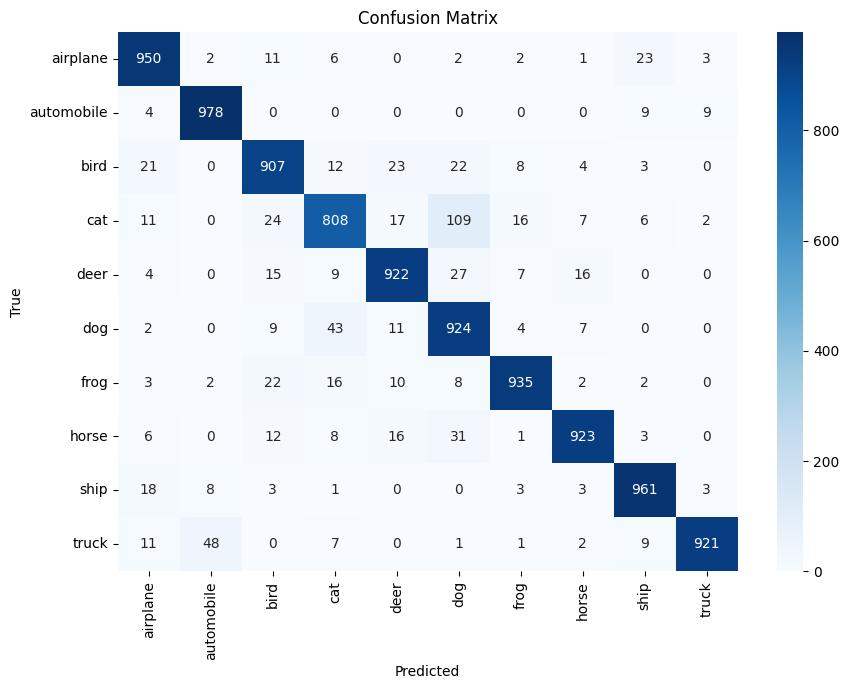

In [29]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

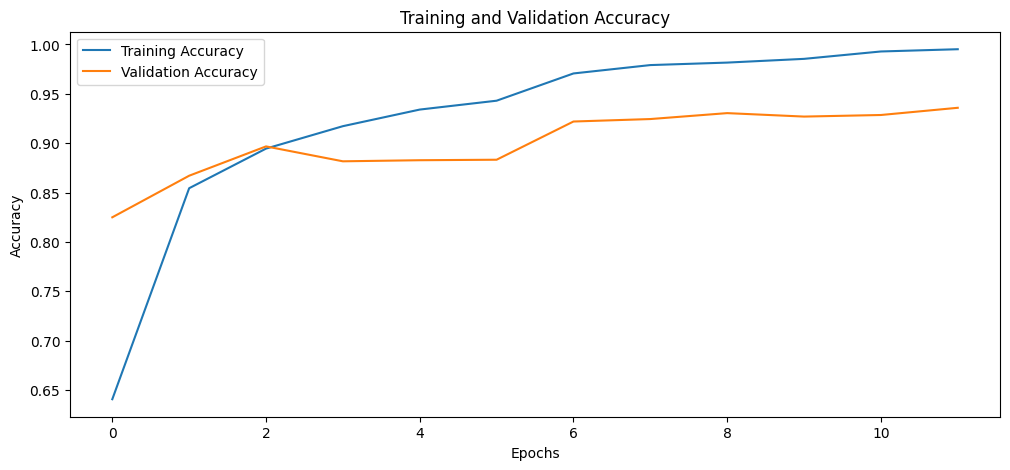

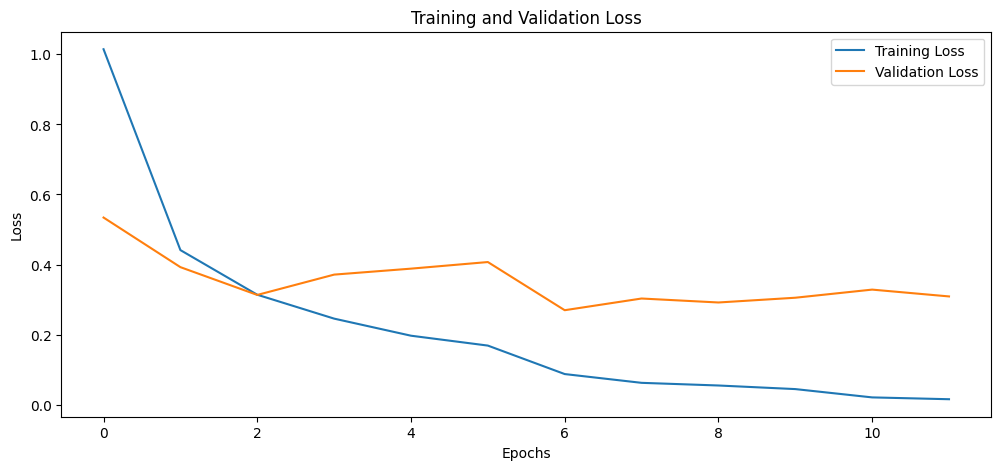

In [30]:
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [34]:
model.save('VGG16_model2.h5')

# **Comparison between the models**

In [35]:
import pickle
with open("Transferflow2.pkl", "wb") as f:
    pickle.dump(history.history, f)